In [1]:
#Manage
import os
import random
import time

#Utils
import numpy as np
import pandas as pd

##plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

##ai_utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [7]:
EPOCHS = 30
BATCH_SIZE = 128
LR = 0.001
WEIGHT_DECAY = 0.0001
SEED = 42

CLASSES = ['airplane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck']

DATA_DIR    = './data'
RESULTS_DIR = './results'

os.makedirs(RESULTS_DIR, exist_ok=True)

In [8]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [9]:
print(f'PyTorch version : {torch.__version__}')
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
    DEVICE = torch.device('cpu')
    print('Using CPU')

print(f'Device: {DEVICE}')
print('Cores:', os.cpu_count())

PyTorch version : 2.9.1+cu130
Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Device: cuda
Cores: 12


## Calculation
Computing the mean and standard deviations for faster processing by normalizing data.

In [10]:
raw_dataset = datasets.CIFAR10( root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

loader = DataLoader(raw_dataset, batch_size=1000, shuffle=False, num_workers=2)

channel_sum    = torch.zeros(3)
channel_sum_sq = torch.zeros(3)
total_pixels   = 0

for images, _ in loader:
    batch_size = images.size(0)
    images = images.view(batch_size, 3, -1)

    channel_sum    += images.sum(dim=[0, 2])
    channel_sum_sq += (images ** 2).sum(dim=[0, 2])
    total_pixels   += batch_size * 32 * 32

mean = channel_sum / total_pixels
std  = torch.sqrt(channel_sum_sq / total_pixels - mean ** 2)

print(f"Mean: {mean}")
print(f"Std:  {std}")

e:\College\AI\aienv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Mean: tensor([0.4914, 0.4822, 0.4465])
Std:  tensor([0.2470, 0.2435, 0.2616])


# Reducing Overfitting (Data Augmentatin)

We are basically adding artifical variance in the dataset

In [11]:
# CONSTS
MEAN = mean
STD = std


# Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# Using provided test train set
train_dataset = datasets.CIFAR10(root=DATA_DIR, train=True,  download=True, transform=train_transform)
test_dataset  = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_transform)

# Appying the Augmentation
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
test_loader   = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f'Train: {len(train_dataset):,} samples | Test: {len(test_dataset):,} samples')
print(f'Train batches: {len(train_loader)} | Test batches: {len(test_loader)}')

Train: 50,000 samples | Test: 10,000 samples
Train batches: 391 | Test batches: 79


C:\Users\VicTuS\AppData\Local\Temp\ipykernel_15168\2188453537.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img = np.clip(img * np.array(STD) + np.array(MEAN), 0, 1)


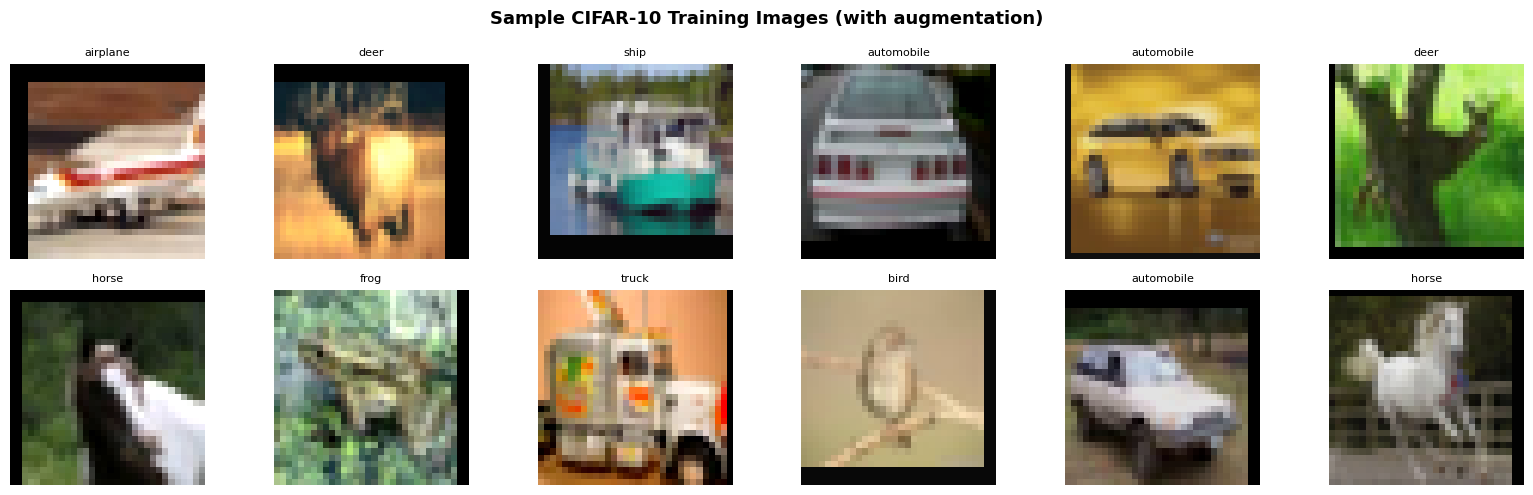

In [12]:
def imshow(img_tensor, title=None):
    img = img_tensor.numpy().transpose((1, 2, 0)) # changing into poytorh format
    img = np.clip(img * np.array(STD) + np.array(MEAN), 0, 1)
    plt.imshow(img)
    if title: plt.title(title, fontsize=8)
    plt.axis('off')

images, labels = next(iter(train_loader))
fig, axes = plt.subplots(2, 6, figsize=(16, 5))
for i, ax in enumerate(axes.flat):
    plt.sca(ax)
    imshow(images[i], CLASSES[labels[i]])
plt.suptitle('Sample CIFAR-10 Training Images (with augmentation)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/sample_images.png', dpi=120, bbox_inches='tight')
plt.show()

In [13]:
class SimpleNN(nn.Module):
    def __init__(self, dropout_rate=0.4):
        """
        We are using 3*32*32 = 3072 features as input
        The output is 10 classes

        In simple NN we loose the spatial information since we flatten the image
        The BatchNormal is used to reduce computation time using the current batch
         - std dev - mean
        Droupout is used to prevent overfitting by cutting off impact of some neurons
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(), # Flattening of spatial data occours here

            nn.Linear(3*32*32, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(256, 10),
        )

    def forward(self, x):
        return self.net(x)

In [20]:
class AlexNetCIFAR(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super().__init__()
        """
        Here We implement the AlexNet architecture for CIFAR-10 dataset
        We are using 3*32*32 2d images as input

        There are 8 layers in total
        There are 5 layers of convolution and 3 layers of fully connected
        2 max pool layer within the 5 Convolutional layers to reduce the size of the data
        This architecture is a copy of the AlexNet architecture as provided in the resource


        The output is 10 classes
        """

        # Convolutional Layer
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))

        # Fully Connected Layer
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

        self._init_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01); nn.init.zeros_(m.bias)

In [21]:
class ConvBlock(nn.Module):
    """
    Basic Block for CNN
    Helper class for TinyVGG
    used instead of repeating the same code multiple times
    """
    def __init__(self, in_ch, out_ch, kernel=3, pad=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel, padding=pad),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.block(x)


class TinyVGG(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.3):
        super().__init__()
        """
        Tiny VGG implementation
        """

        self.block1 = nn.Sequential(
            ConvBlock(3, 32), ConvBlock(32, 32),
            nn.MaxPool2d(2, 2),#32 to 16
            nn.Dropout2d(dropout_rate),
        )
        self.block2 = nn.Sequential(
            ConvBlock(32, 64), ConvBlock(64, 64),
            nn.MaxPool2d(2, 2),# 16 to 8
            nn.Dropout2d(dropout_rate),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),# hence here 64x8x8
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes),
        )
        self._init_weights()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return self.classifier(x)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight); nn.init.zeros_(m.bias)

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

models = {
    'SimpleNN': SimpleNN(dropout_rate=0.4),
    'AlexNet':  AlexNetCIFAR(num_classes=10, dropout_rate=0.5),
    'TinyVGG':  TinyVGG(num_classes=10, dropout_rate=0.3),
}

print('Model Parameter Counts:')
print('-' * 40)
for name, model in models.items():
    params = count_parameters(model)
    print(f'  {name:10s}: {params:>10,} parameters')

Model Parameter Counts:
----------------------------------------
  SimpleNN  :  3,809,034 parameters
  AlexNet   :  7,175,754 parameters
  TinyVGG   :  1,117,354 parameters


In [23]:
def train_one_epoch(model, loader, optimizer, criterion, device, scaler=None):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        if scaler:
            with torch.cuda.amp.autocast():
                out  = model(images)
                loss = criterion(out, labels)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            out  = model(images)
            loss = criterion(out, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item() * images.size(0)
        correct    += out.argmax(1).eq(labels).sum().item()
        total      += images.size(0)

    return total_loss/total, 100.0*correct/total


def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            out  = model(images)
            loss = criterion(out, labels)
            total_loss += loss.item() * images.size(0)
            correct    += out.argmax(1).eq(labels).sum().item()
            total      += images.size(0)

    return total_loss/total, 100.0*correct/total


def train_model(model, name, train_loader, test_loader,
                device, epochs=EPOCHS, lr=LR, wd=WEIGHT_DECAY):

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
    scaler    = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

    history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[]}
    best_acc = 0.0

    print(f'\n{"="*55}')
    ##print(f'  Training: {name}  ({count_parameters(model):,} params)')
    print(f'{"="*55}')

    start = time.time()
    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler)
        te_loss, te_acc = eval_epoch(model, test_loader, criterion, device)
        scheduler.step()

        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['test_loss'].append(te_loss)
        history['test_acc'].append(te_acc)

        if te_acc > best_acc:
            best_acc = te_acc
            torch.save(model.state_dict(), f'{name.lower()}_best.pth')

        if epoch % 5 == 0 or epoch == 1:
            print(f'  Epoch [{epoch:3d}/{epochs}] '
                  f'Train Loss: {tr_loss:.4f} Acc: {tr_acc:.2f}% | '
                  f'Test Loss: {te_loss:.4f} Acc: {te_acc:.2f}%')

    elapsed = time.time() - start
    history['total_time'] = elapsed
    history['best_acc']   = best_acc
    print(f'\n  ✓ Best Test Acc: {best_acc:.2f}%  |  Time: {elapsed:.1f}s ({elapsed/60:.1f} min)')
    return history

In [25]:
histories = {}
for name, model in models.items():
    histories[name] = train_model(
        model, name, train_loader, test_loader, DEVICE
    )

C:\Users\VicTuS\AppData\Local\Temp\ipykernel_15168\3860108515.py:55: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None


C:\Users\VicTuS\AppData\Local\Temp\ipykernel_15168\3860108515.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch [  1/30] Train Loss: 1.7065 Acc: 44.55% | Test Loss: 1.5529 Acc: 52.79%
  Epoch [  5/30] Train Loss: 1.7071 Acc: 44.35% | Test Loss: 1.5584 Acc: 51.35%
  Epoch [ 10/30] Train Loss: 1.6900 Acc: 45.17% | Test Loss: 1.5296 Acc: 53.01%
  Epoch [ 15/30] Train Loss: 1.6620 Acc: 46.71% | Test Loss: 1.4996 Acc: 54.31%
  Epoch [ 20/30] Train Loss: 1.6227 Acc: 48.38% | Test Loss: 1.4709 Acc: 55.55%
  Epoch [ 25/30] Train Loss: 1.5845 Acc: 50.44% | Test Loss: 1.4505 Acc: 56.68%
  Epoch [ 30/30] Train Loss: 1.5688 Acc: 51.42% | Test Loss: 1.4417 Acc: 56.88%

  ✓ Best Test Acc: 57.01%  |  Time: 1104.7s (18.4 min)

  Epoch [  1/30] Train Loss: 1.2949 Acc: 64.72% | Test Loss: 1.2588 Acc: 66.60%
  Epoch [  5/30] Train Loss: 1.0734 Acc: 75.80% | Test Loss: 1.1394 Acc: 72.29%
  Epoch [ 10/30] Train Loss: 0.9112 Acc: 83.05% | Test Loss: 1.1172 Acc: 75.36%
  Epoch [ 15/30] Train Loss: 0.7954 Acc: 88.09% | Test Loss: 0.8107 Acc: 86.91%
  Epoch [ 20/30] Train Loss: 0.6991 Acc: 92.12% | Test Loss: 0.

In [29]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def compute_all_metrics(model, loader, device, class_names=CLASSES):
    model.eval()
    all_preds, all_targets, all_outputs = [], [], []

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out  = model(imgs)
            all_outputs.append(out.cpu())
            all_preds.extend(out.argmax(1).cpu().numpy())
            all_targets.extend(lbls.cpu().numpy())

    outputs_tensor = torch.cat(all_outputs)
    preds   = np.array(all_preds)
    targets = np.array(all_targets)

    return {
        'accuracy':  accuracy_score(targets, preds) * 100,
        'precision': precision_score(targets, preds, average='macro', zero_division=0) * 100,
        'recall':    recall_score(targets, preds, average='macro', zero_division=0) * 100,
        'f1':        f1_score(targets, preds, average='macro', zero_division=0) * 100,
        'cm':        confusion_matrix(targets, preds),
        'report':    classification_report(targets, preds, target_names=class_names, zero_division=0),
        'preds':     preds,
        'targets':   targets,
    }

all_metrics = {}
print('Computing test set metrics...')
for name, model in models.items():
    all_metrics[name] = compute_all_metrics(model, test_loader, DEVICE)
    m = all_metrics[name]
    print(f'\n  {name}: Acc={m["accuracy"]:.2f}%  P={m["precision"]:.2f}%  '
          f'R={m["recall"]:.2f}%  F1={m["f1"]:.2f}% ')

Computing test set metrics...

  SimpleNN: Acc=56.88%  P=56.35%  R=56.88%  F1=56.18% 

  AlexNet: Acc=91.08%  P=91.06%  R=91.08%  F1=91.06% 

  TinyVGG: Acc=77.27%  P=77.17%  R=77.27%  F1=76.98% 


In [30]:
for name, m in all_metrics.items():
    print(f'\n{"-"*55}')
    print(f'  Classification Report — {name}')
    print(f'{"-"*55}')
    print(m['report'])


-------------------------------------------------------
  Classification Report — SimpleNN
-------------------------------------------------------
              precision    recall  f1-score   support

    airplane       0.64      0.61      0.62      1000
  automobile       0.65      0.71      0.67      1000
        bird       0.50      0.39      0.44      1000
         cat       0.43      0.35      0.38      1000
        deer       0.55      0.41      0.47      1000
         dog       0.48      0.46      0.47      1000
        frog       0.60      0.66      0.63      1000
       horse       0.57      0.70      0.63      1000
        ship       0.68      0.70      0.69      1000
       truck       0.54      0.70      0.61      1000

    accuracy                           0.57     10000
   macro avg       0.56      0.57      0.56     10000
weighted avg       0.56      0.57      0.56     10000


-------------------------------------------------------
  Classification Report — AlexNet
--

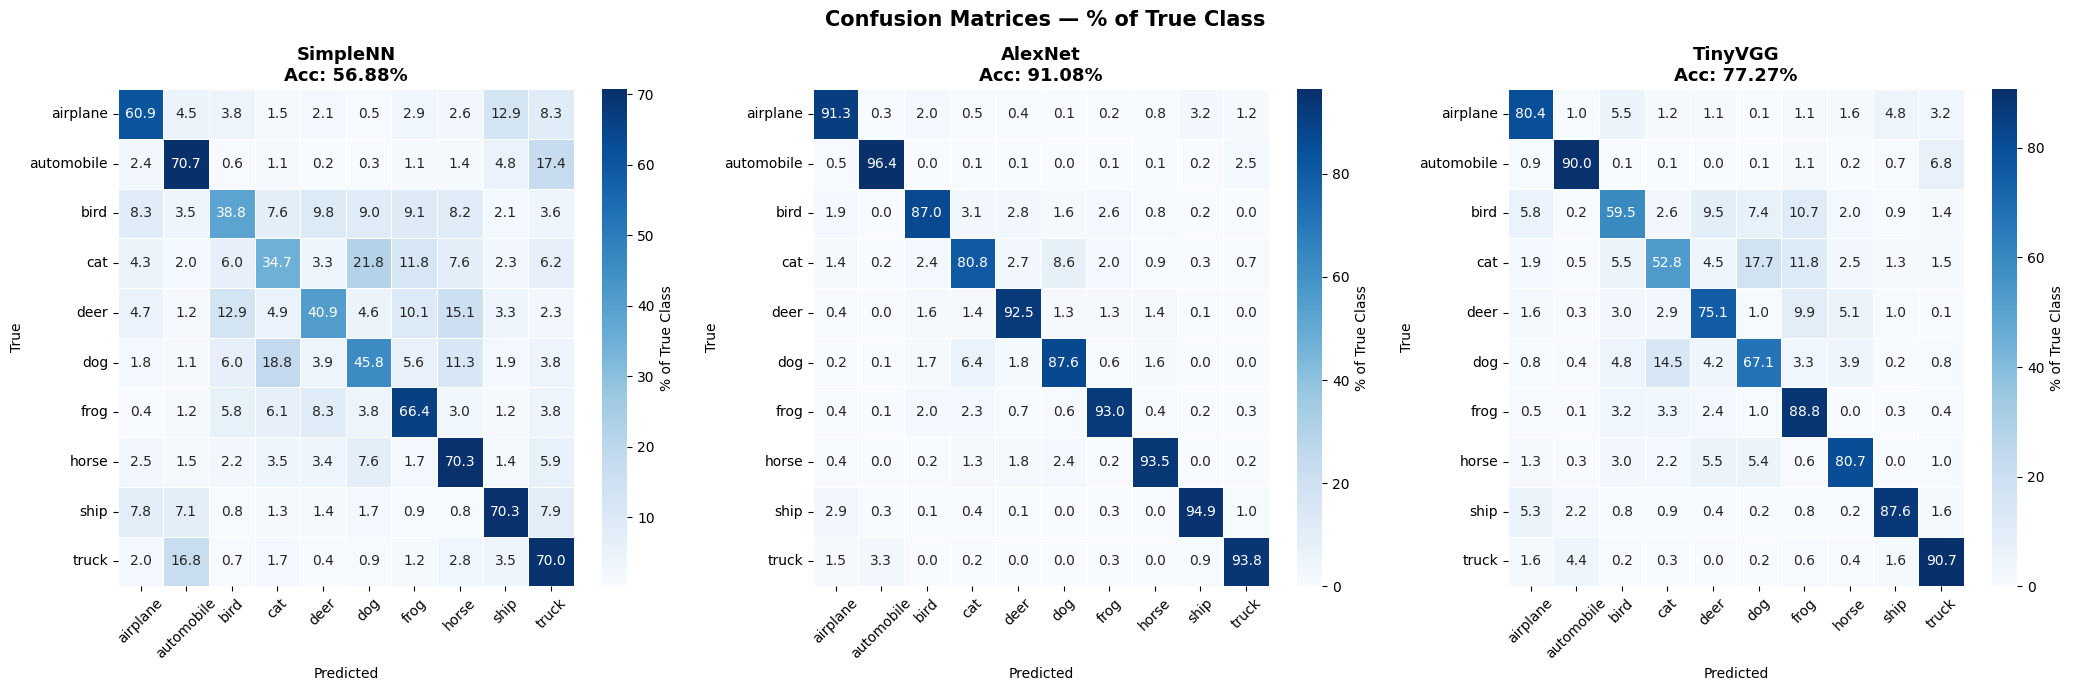

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

for ax, (name, m) in zip(axes, all_metrics.items()):
    cm_pct = m['cm'].astype(float) / m['cm'].sum(axis=1, keepdims=True) * 100
    sns.heatmap(cm_pct, ax=ax, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES,
                cbar_kws={'label': '% of True Class'}, linewidths=0.4)
    ax.set_title(f'{name}\nAcc: {m["accuracy"]:.2f}%', fontsize=13, fontweight='bold')
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Confusion Matrices — % of True Class', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

In [32]:
rows = []
for name in all_metrics:
    m = all_metrics[name]
    h = histories[name]
    rows.append({
        'Model':          name,
        'Accuracy (%)':   round(m['accuracy'],  2),
        'Precision (%)':  round(m['precision'], 2),
        'Recall (%)':     round(m['recall'],    2),
        'F1 (%)':         round(m['f1'],        2),
        'Params (K)':     round(count_parameters(models[name]) / 1000, 1),
        'Train Time (s)': round(h['total_time'], 1),
    })

df = pd.DataFrame(rows).set_index('Model')
print('\n' + '='*75)
print('  FINAL COMPARISON TABLE')
print('='*75)
print(df.to_string())
print('='*75)
df


  FINAL COMPARISON TABLE
          Accuracy (%)  Precision (%)  Recall (%)  F1 (%)  Params (K)  Train Time (s)
Model                                                                                
SimpleNN         56.88          56.35       56.88   56.18      3809.0          1104.7
AlexNet          91.08          91.06       91.08   91.06      7175.8          1481.9
TinyVGG          77.27          77.17       77.27   76.98      1117.4           961.4


,Accuracy (%),Precision (%),Recall (%),F1 (%),Params (K),Train Time (s)
Model,,,,,,
SimpleNN,56.88,56.35,56.88,56.18,3809.0,1104.7
AlexNet,91.08,91.06,91.08,91.06,7175.8,1481.9
TinyVGG,77.27,77.17,77.27,76.98,1117.4,961.4


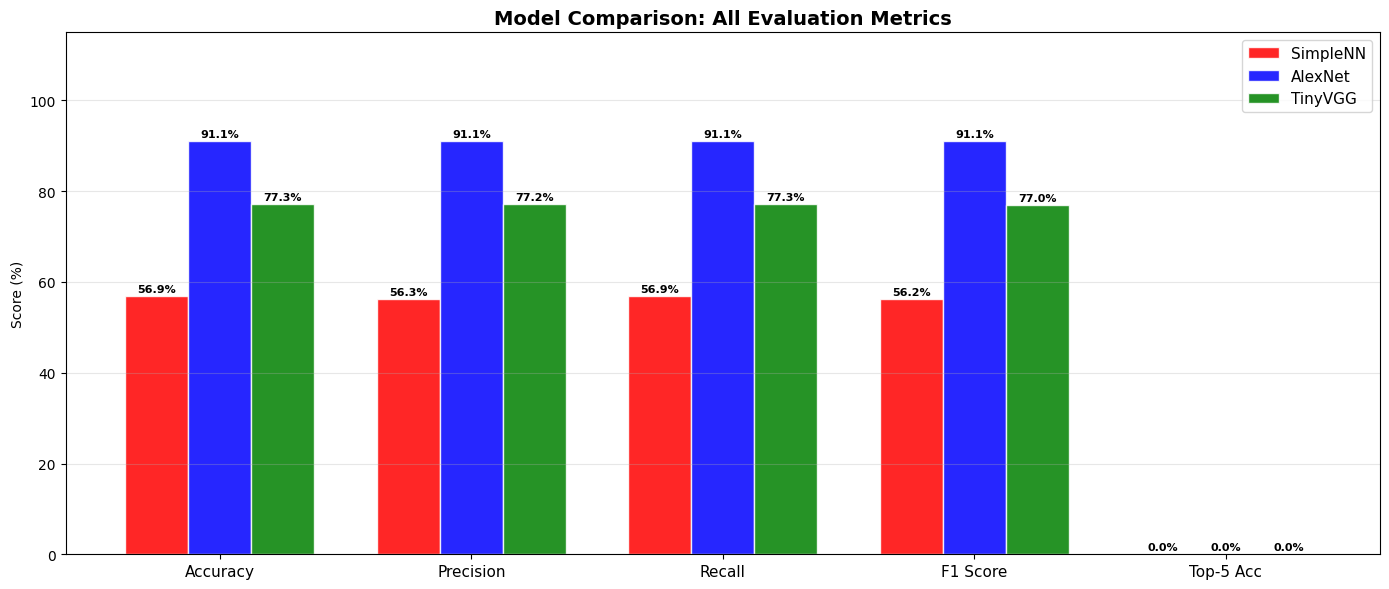

In [35]:
metric_keys   = ['accuracy', 'precision', 'recall', 'f1', 'top5_acc']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Top-5 Acc']
names  = list(all_metrics.keys())
x      = np.arange(len(metric_keys))
width  = 0.25
colors_list = ['red', 'blue', 'green']

fig, ax = plt.subplots(figsize=(14, 6))
for i, (name, color) in enumerate(zip(names, colors_list)):
    vals = [all_metrics[name].get(k, 0) for k in metric_keys]
    bars = ax.bar(x + i*width, vals, width, label=name, color=color, alpha=0.85, edgecolor='white')
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.4,
                f'{v:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')

ax.set_xticks(x + width); ax.set_xticklabels(metric_labels, fontsize=11)
ax.set_ylabel('Score (%)'); ax.set_ylim(0, 115)
ax.set_title('Model Comparison: All Evaluation Metrics', fontsize=14, fontweight='bold')
ax.legend(fontsize=11); ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/metric_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

Discussion & Conclusion
Why AlexNet Was Important

Before 2012, image classification mostly used hand-crafted features like SIFT and HOG with SVM classifiers. AlexNet proved that deep CNNs can automatically learn features from images and perform much better.

Its main improvements were:

ReLU activation – Faster training and better gradient flow compared to sigmoid/tanh.

Dropout – Reduced overfitting by randomly turning off neurons during training.

GPU training – Allowed a larger and deeper model to be trained efficiently.

Data augmentation – Random crops and flips improved generalization.

LRN – Helped improve generalization (later replaced by BatchNorm).